# XOR

_Aside: Should do [Working efficiently with jupyter lab](https://florianwilhelm.info/2018/11/working_efficiently_with_jupyter_lab/)_

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
#%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Fetch our tools:

In [3]:
from nn import Network, Layer, IdentityLayer, AffineLayer, MapLayer
from nnbench import NNBench
from nnvis import NNVis

___

## Construct a network to learn exclusive-or
We make a two-input, one-output network, using
a 2x2 affine followed by tanh activation
feeding a 2x1 affine followed by tanh activation:

In [4]:
net = Network()
net.extend(AffineLayer(2,2))
net.extend(MapLayer(np.tanh, lambda d: 1.0 - np.tanh(d)**2))
net.extend(AffineLayer(2,1))
net.extend(MapLayer(np.tanh, lambda d: 1.0 - np.tanh(d)**2))

Make a test bench and a visualizer:

In [5]:
bench = NNBench(net)
vis = NNVis(bench)

Prepare fixed training data for the learning process _[improve]_:

In [6]:
dat = \
[(np.array([-1,-1]), np.array([-1])),
 (np.array([-1,1]), np.array([1])),
 (np.array([1,1]), np.array([-1])),
 (np.array([1,-1]), np.array([1]))]
dc = 0
amp= 1
temp = [(d[0]*amp/2+dc,d[1]*amp/2+dc) for d in dat]

bench.training_data = ((np.array([v[0] for v in temp]),
                        np.array([v[1] for v in temp])),)
bench.training_data

((array([[-0.5, -0.5],
         [-0.5,  0.5],
         [ 0.5,  0.5],
         [ 0.5, -0.5]]),
  array([[-0.5],
         [ 0.5],
         [-0.5],
         [ 0.5]])),)

Set the test bench to use the fixed training data for learning:

In [7]:
bench.training_data_gen = bench.training_data_gen_fixed

We can extract the learnable parameters from a net. They can be modified and injected back if we wish.

In [8]:
net.state_vector()

array([-0.14992148,  0.5491558 , -0.80861928, -0.8753007 ,  0.89149504,
        1.53531709, -1.61588961,  0.46541901,  0.15904194])

Set the state to an ordinary example starting point, for consistent notebook behavior below. We also make it the checkpoint in the bench.

In [9]:
net.set_state_from_vector(np.array([-0.88681521, -1.28596788,  0.3248974 , -2.33838503,  0.34761944,
       -0.94541789,  1.99448043,  0.38704839, -3.8844268 ]))
bench.checkpoint_net()

How does this untrained net work across the canonical input domain?

In [10]:
domain = bench.training_data[0][0]
domain, net(domain)

(array([[-0.5, -0.5],
        [-0.5,  0.5],
        [ 0.5,  0.5],
        [ 0.5, -0.5]]),
 array([[-0.9866814 ],
        [-0.99192615],
        [-0.99948859],
        [-0.99977295]]))

Not the ideal answer, which is:

In [11]:
bench.training_data[0][1]

array([[-0.5],
       [ 0.5],
       [-0.5],
       [ 0.5]])

# Learning
This net doesn't know how to do `xor` yet. Let's try teaching it. \
We can plot the loss as a function of learning steps, for the current learning rate $\eta$: 

In [12]:
vis.plot_learning(100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The net has changed state from that learning:

In [13]:
bench.net.state_vector()

array([-0.85675932, -1.65920239, -0.85792356, -2.21288072,  1.36151883,
       -1.17040574,  2.897001  , -0.87701926, -2.73760289])

How well does it work now?

In [14]:
net(domain)

array([[-0.44097524],
       [ 0.52773348],
       [-0.47448116],
       [ 0.40378648]])

Good. We can learn some more, carrying on from where we left off:

In [15]:
vis.plot_learning(100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The net is again changed:

In [16]:
bench.net.state_vector()

array([-0.78585668, -1.73135459, -0.97595716, -2.18541149,  1.34156069,
       -1.18936607,  2.89047085, -0.96059319, -2.75105728])

Check its behavior now:

In [17]:
net(domain)

array([[-0.49942644],
       [ 0.50191512],
       [-0.50000722],
       [ 0.49760595]])

We can get to floating-point-$\epsilon$ perfect with more training. Let's add 800 more, for a total of a thousand learning cycles:

In [18]:
_ = bench.learn(800)

In [19]:
net(domain)

array([[-0.5],
       [ 0.5],
       [-0.5],
       [ 0.5]])

It's well-trained, at least for the canonical inputs. What was the resultant net?

In [20]:
bench.net.state_vector()

array([-0.78243386, -1.73327914, -0.97914882, -2.18419349,  1.34108655,
       -1.19007785,  2.89040997, -0.9616282 , -2.75121581])

## Visualizing the learning process

Let's look at the loss as a function of learning steps and learning rate $\eta$. Get back to our starting point network.

In [21]:
bench.rollback_net()

Move the sliders to adjust the number of learning steps, and the learning rate:

In [22]:
vis.knobs_plot_learning(100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

How well does it work after this training?

In [23]:
net(domain)

array([[-0.44097524],
       [ 0.52773348],
       [-0.47448116],
       [ 0.40378648]])

## Viewing the loss surface
We can plot the loss surface with `plotly`:

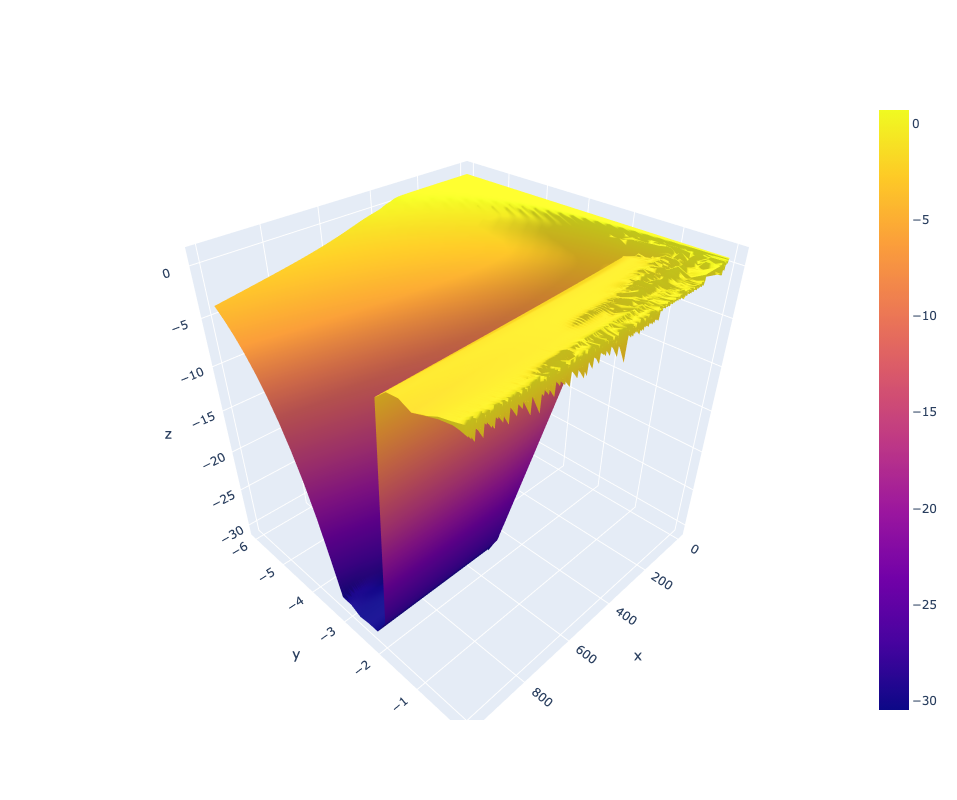

In [24]:
bench.rollback_net() if True else bench.randomize_net()
rates = np.logspace(-6, 0, base=2, num=25)
cube = bench.learn_loss_cube(1000, rates)
vis.plot_loss_cube()

## The track that learning takes
Let us examine the trajectory in state space during learning, and the loss function.
Each learning iteration changes the net state. We can examine those deltas.
Questions:
1. Are there regimes of direction-of-change (DoC) in state space, or does the DoC wander chaotically?
1. What are the spectral characteristics of the DoC? Length characteristics?
1. How do the DoC characteristics relate to the loss function, and it's first difference?
1. How do these trajectories vary with learning rate? Are there clues in these to adapt the learning rate?
1. How do the trajectory characteristics vary across different starting nets?
1. How do these measures vary with the objective function of the learning process, that is, what you're trying to teach the net?
1. How do the different layers with learning state evolve? Do they settle at different times? How does an upstream layer change, as a consequence of learning, affect downstream layers? Down affect up?

In [25]:
bench.rollback_net()
bench.net.eta = 0.3
learned_track = bench.learn_track(2000)

In [26]:
traja = bench.analyze_learning_track(learned_track)

In [27]:
# Development space for plotting:
if True:
    fig, ax = plt.subplots()  # Create a figure and an axes.
    traj_color = 'xkcd:red'
    loss_color = 'xkcd:blue'
    cos_color = 'xkcd:green'
    ax.set_xlabel('$n$')  # Add an x-label to the axes.
    ax.set_ylabel('$|\Delta state|$', color=traj_color)
    ax.tick_params(axis='y', labelcolor=traj_color)
    ax.set_title(f"$\eta={bench.net.eta}$")  # Add a title to the axes.
    ax.set_yscale('log')
    tnl, = ax.plot(traja.traj_L2, label=f"traj norm", color=traj_color)  # Plot some data on the axes.
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.tick_params(axis='y', labelcolor=loss_color)
    dll, = ax2.plot(traja.loss_steps, label=f"$\Delta loss$", color=loss_color)  # Plot some data on the axes.
    cosl, = ax2.plot(traja.traj_cos, label=f"$\Delta state cosine$", color=cos_color)
    ax.legend([tnl, dll, cosl], ["$\\|\\Delta state \\|$", "$\\Delta loss$", "$cos(\\theta)\Delta$"])  # Add a legend.
    #ax2.legend()  # Add a legend.
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

---

# Scratch

In [28]:
assert False, "Stop notebook execution here if entering from above"

AssertionError: Stop notebook execution here if entering from above

In [ ]:
bench.randomize_net()
t = bench.learn(1000)

In [ ]:
bench.net.state_vector()

In [ ]:
net = bench.net
net([[-.5, -.5], [-.5, .5]])

In [ ]:
net.layers

In [ ]:
from nnbench import Thing

In [ ]:
t = Thing(color='brown', weight=7)

In [ ]:
t.cow = 'moo'

In [ ]:
t.cow

In [ ]:
t.color

---

In [ ]:
# Boneyard

In [ ]:
assert False, "Stop notebook execution, the rest is scrap"

Wrangle the state-space trajectory and the losses into form.

In [ ]:
trajectory = np.vstack([v[0] for v in lt])
losses = np.vstack([v[1] for v in lt])

Take first differences, which represent the changes at each step

In [ ]:
traj_steps = np.diff(trajectory, axis=0)
loss_steps = np.diff(losses, axis=0)

In [ ]:
traj_steps[:5]

Find the L2 norm of the trajectory steps $\lVert traj \rVert$:

In [ ]:
traj_L2 = np.sqrt(np.einsum('...i,...i', traj_steps, traj_steps))

In [ ]:
len(traj_L2), traj_L2[:5], traj_L2[-5:]

Find the angles between trajectory steps, from
$$\mathbf {a} \cdot \mathbf {b} = \left\|\mathbf {a} \right\|\left\|\mathbf {b} \right\|\cos \theta \\
\cos \theta = \frac{\mathbf {a} \cdot \mathbf {b}}{\left\|\mathbf {a} \right\|\left\|\mathbf {b} \right\|} \\
$$
where $\mathbf {a}$ and $\mathbf {b}$ are a state-space trajectory step and the succeeding step respectively

Find $\mathbf {a} \cdot \mathbf {b}$:

In [ ]:
trajn_dot_nplus1 = np.einsum('...i,...i', traj_steps[:-1], traj_steps[1:])
trajn_dot_nplus1[:5], np.any(trajn_dot_nplus1 < 0)

Find $\left\|\mathbf {a} \right\|\left\|\mathbf {b} \right\|$:

In [ ]:
traj_cos_denom = np.multiply(traj_L2[:-1], traj_L2[1:])

This will be the divisor. Some entries may be zero, so we adapt

In [ ]:
len(traj_L2) - np.count_nonzero(traj_L2)

In [ ]:
np.equal(traj_L2, 0)

Find $\cos \theta$ by dividing, excluding division by zero:

In [ ]:
traj_cos = np.divide(trajn_dot_nplus1, traj_cos_denom, where=traj_cos_denom!=0.0)
traj_cos[:5], traj_cos[-5:], min(traj_cos), max(traj_cos)

In [ ]:
#traj_theta = np.arccos(traj_cos)
#traj_theta[:5], traj_theta[-5:]

In [ ]:
net = Network()
net.extend(AffineLayer(2,2))
#leak = 0
#net.extend(MapLayer(lambda x: (x*(1+leak/2)+abs(x)*(1-leak/2))/2, lambda d: [leak,1][1 if d>0 else 0]))
#net.extend(MapLayer(lambda x: max(0, np.sign(x)) * x, lambda d: max(0, np.sign(d))))
net.extend(MapLayer(np.tanh, lambda d: 1.0 - np.tanh(d)**2))
net.extend(AffineLayer(2,1))
net.extend(MapLayer(np.tanh, lambda d: 1.0 - np.tanh(d)**2))
#sigmoid = lambda x: 1/(np.exp(x)+1)
#net.extend(MapLayer(sigmoid, lambda d: sigmoid(d)*(1-sigmoid(d))))
#net.extend(MapLayer(lambda x: max(0, np.sign(x)) * x, lambda d: max(0, np.sign(d))))